In [2]:
import gym
import torch
from darc import DARC
from sac import ContSAC
from broken_joint import BrokenJointEnv
import matplotlib.pyplot as plt
import numpy as np
from utils import *

env_name = 'Humanoid-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

device = 'cuda'

state dim is: 376 and action dim is: 17


In [3]:
policy_config = {
    "input_dim": [state_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "split1", "sizes": [action_dim, action_dim]}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
value_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "linear2", "size": 1}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sa_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sas_config = {
    "input_dim": [state_dim * 2 + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}

# broken source

In [4]:
env_name = 'Humanoid-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

state dim is: 376 and action dim is: 17


In [5]:
# set current device
torch.cuda.set_device(1)
device = 'cuda'

In [5]:
running_state = ZFilter((state_dim,), clip=10)
model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, "cuda", ent_adj=True,
             n_updates_per_train=1,lr=3e-4,max_steps=200,batch_size=256,
             savefolder='broken_source_humanoid_200steps',running_mean=running_state,if_normalize = True)

src, tgt = model.train(5000, deterministic=False)

TARGET: index: 0, steps: 30, total_rewards: 153.50889649607842
SOURCE: index: 0, steps: 24, total_rewards: 119.4991291541162
TARGET: index: 1, steps: 23, total_rewards: 115.67936651736571
SOURCE: index: 1, steps: 28, total_rewards: 141.67991070314437
TARGET: index: 2, steps: 19, total_rewards: 95.41416365647387
SOURCE: index: 2, steps: 19, total_rewards: 94.84269786250033
TARGET: index: 3, steps: 33, total_rewards: 168.48344013230286
SOURCE: index: 3, steps: 25, total_rewards: 125.51351884011123
TARGET: index: 4, steps: 34, total_rewards: 169.45102027218172
SOURCE: index: 4, steps: 17, total_rewards: 83.64411287187683
TARGET: index: 5, steps: 23, total_rewards: 117.42607085047167
SOURCE: index: 5, steps: 17, total_rewards: 84.55577067149478
TARGET: index: 6, steps: 20, total_rewards: 100.15498220366253
SOURCE: index: 6, steps: 21, total_rewards: 108.53355175751604
TARGET: index: 7, steps: 19, total_rewards: 94.89012442093515
SOURCE: index: 7, steps: 21, total_rewards: 105.8198485753468

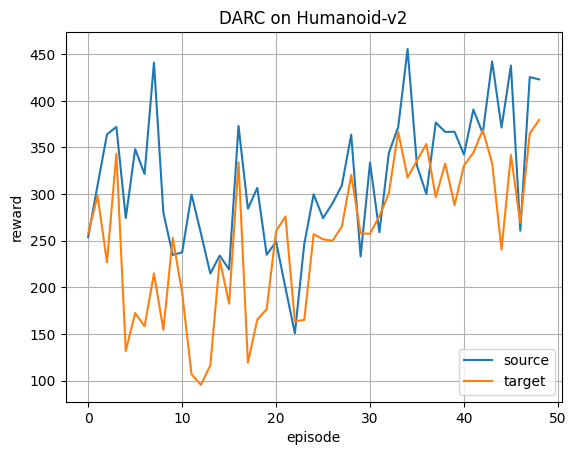

In [9]:
length = list(range(len(src)))
plt.plot(length, src, label="source")
plt.plot(length, tgt, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("DARC on {}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [6]:
import gym
import argparse
import numpy as np
from darc import DARC
from broken_joint import BrokenJointEnv
import os
import torch
from utils import *
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import sys
import pickle
import time
from gail import GailContSAC_SRC
from src_gailsac_classifier import GailContSAC_SRC_Classifier

In [7]:
render = 'store_true'
log_std = -0.0
gamma = 0.99
tau = 0.95
lr_reg = 1e-3
learning_rate = 5e-5
clip_epsilon = 0.01
num_threads = 1
seed = 1
min_batch_size = 2048
eval_batch_size = 2048
max_iter_num = 15000
log_interval = 1
save_model_path = ''
max_expert_state_num = 1000
train_steps = 2000
episode_length = 200
save_file_name = ''
optim_epochs = 3


env_name = 'Humanoid-v2'
env = gym.make(env_name)

def lr_decay(actor_optim,cirtic_optim, total_steps,max_steps):
    if total_steps > 7000:
        lr_a_now = learning_rate * (1 - (total_steps-7000) /(max_steps))
        for p in actor_optim.param_groups:
            p['lr'] = lr_a_now
        for p in cirtic_optim.param_groups:
            p['lr'] = lr_a_now
    return actor_optim,cirtic_optim



In [8]:
save_model = 'broken_source_humanoid_200steps/4900'

running_state = ZFilter((state_dim,), clip=10)
expert_model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, device, ent_adj=True,
             n_updates_per_train=1, max_steps = 200, batch_size=256, savefolder ='none') 
expert_model.load_model(save_model, device)
expert_model.running_mean.fix = True


num_steps = 0
expert_traj = []
total_reward = 0
from tqdm import tqdm
for i_episode in tqdm(range(100000)):

    state = source_env.reset()
    reward_episode = 0

    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = source_env.step(action)
        reward_episode += reward
        num_steps += 1
        expert_traj.append(np.hstack([state, next_state]))
        if done or num_steps >= max_expert_state_num:
            break
        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode
    darc_source = total_reward/(i_episode)
    
print('eval on src',darc_source)
expert_traj = np.stack(expert_traj)

total_reward = 0
num_steps = 0
for i_episode in tqdm(range(50)):
    state = target_env.reset()
    reward_episode = 0
    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = target_env.step(action)
        reward_episode += reward
        num_steps += 1
        if done or num_steps >= max_expert_state_num:
            break
        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode
    darc_target = total_reward/(i_episode)
print('eval on tgt',darc_target)




dtype = torch.float32
torch.set_default_dtype(dtype)
is_disc_action = False

  0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipykernel_66926/525482915.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  darc_source = total_reward/(i_episode)
  0%|          | 13/100000 [00:00<2:06:29, 13.18it/s]


eval on src 400.96471747333663


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_66926/525482915.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  darc_target = total_reward/(i_episode)
 92%|█████████▏| 46/50 [00:00<00:00, 62.94it/s]

eval on tgt 109.11376292559639


In [13]:
IL = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 50,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs, tgt_bs, classifier_loss = IL.train(5000, deterministic=False)


index: 0, steps: 21, total_rewards: 108.39068750007908, total_reward_adv: 129.0585, acc gen: 0, acc expert: 0
eval reward: 233.6031936772335
index: 1, steps: 25, total_rewards: 128.30599521022273, total_reward_adv: 133.7021, acc gen: 0, acc expert: 0
index: 2, steps: 18, total_rewards: 88.86088288709425, total_reward_adv: 95.6782, acc gen: 0, acc expert: 0
index: 3, steps: 35, total_rewards: 172.31957197145897, total_reward_adv: 197.7752, acc gen: 0, acc expert: 0
index: 4, steps: 19, total_rewards: 95.35981558131814, total_reward_adv: 96.0247, acc gen: 0, acc expert: 0
index: 5, steps: 23, total_rewards: 115.1283358911425, total_reward_adv: 153.4286, acc gen: 0, acc expert: 0
index: 6, steps: 31, total_rewards: 157.90641517129026, total_reward_adv: 171.7114, acc gen: 0, acc expert: 0
index: 7, steps: 42, total_rewards: 204.91106966494445, total_reward_adv: 256.8208, acc gen: 0, acc expert: 0
index: 8, steps: 31, total_rewards: 152.37728598007513, total_reward_adv: 159.9994, acc gen: 0

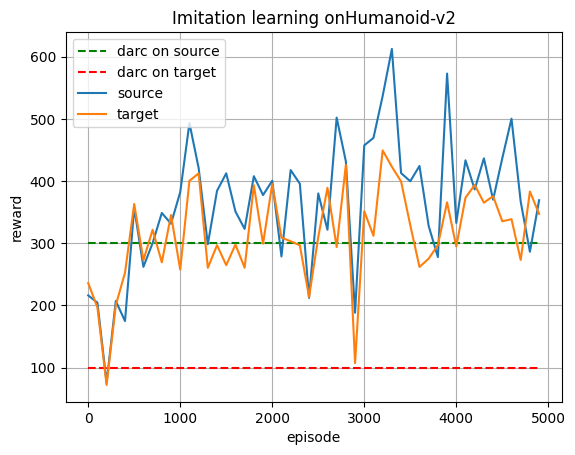

In [14]:
length = np.array(list(range(len(src_bs)))) *100
darc_source = np.ones_like(length) * 300
darc_target = np.ones_like(length) * 100
plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs, label="source")
plt.plot(length, tgt_bs, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


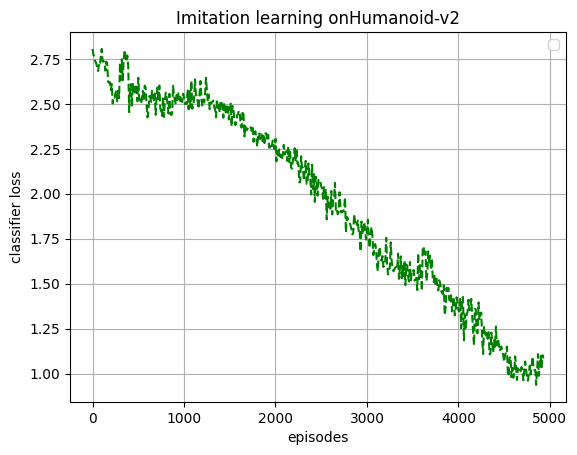

In [15]:
loss_length = np.array(list(range(len(classifier_loss)))) * 10
plt.plot(loss_length, classifier_loss, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [16]:
IL_2 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 5e-5, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 100,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs_2, tgt_bs_2, classifier_loss_2 = IL_2.train(5000, deterministic=False)


index: 0, steps: 21, total_rewards: 105.53232349184569, total_reward_adv: 107.241, acc gen: 0, acc expert: 0
eval reward: 155.54226487021216
index: 1, steps: 18, total_rewards: 88.29225188713488, total_reward_adv: 91.6118, acc gen: 0, acc expert: 0
index: 2, steps: 17, total_rewards: 83.5430941835385, total_reward_adv: 92.7405, acc gen: 0, acc expert: 0
index: 3, steps: 20, total_rewards: 99.90085110711567, total_reward_adv: 100.5192, acc gen: 0, acc expert: 0
index: 4, steps: 21, total_rewards: 105.44769336404771, total_reward_adv: 113.3412, acc gen: 0, acc expert: 0
index: 5, steps: 34, total_rewards: 172.0431850561925, total_reward_adv: 161.3592, acc gen: 0, acc expert: 0
index: 6, steps: 44, total_rewards: 213.72041157609758, total_reward_adv: 223.0081, acc gen: 0, acc expert: 0
index: 7, steps: 33, total_rewards: 166.96168430191003, total_reward_adv: 165.913, acc gen: 0, acc expert: 0
index: 8, steps: 21, total_rewards: 106.90530841302686, total_reward_adv: 108.6843, acc gen: 0, a

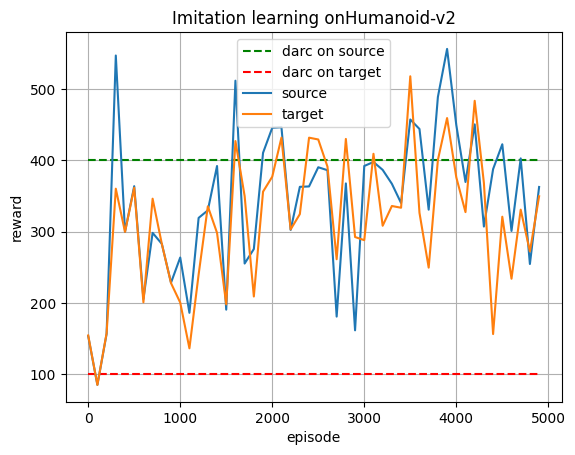

In [25]:
length = np.array(list(range(len(src_bs_2)))) *100
darc_source = np.ones_like(length) * 400
darc_target = np.ones_like(length) * 100
plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_2, label="source")
plt.plot(length, tgt_bs_2, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


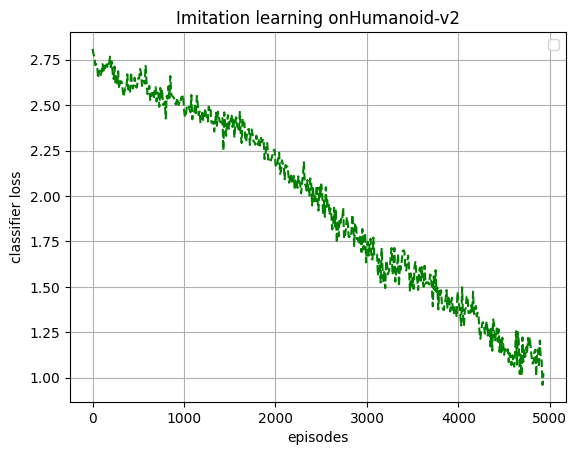

In [18]:
loss_length_2 = np.array(list(range(len(classifier_loss_2)))) * 10
plt.plot(loss_length_2, classifier_loss_2, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [22]:
IL_3 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 100,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs_3, tgt_bs_3, classifier_loss_3 = IL_3.train(5000, deterministic=False)


index: 0, steps: 17, total_rewards: 83.52568051691058, total_reward_adv: 83.8411, acc gen: 0, acc expert: 0
eval reward: 275.88959074755724
index: 1, steps: 17, total_rewards: 83.91124712499887, total_reward_adv: 82.5288, acc gen: 0, acc expert: 0
index: 2, steps: 22, total_rewards: 111.7350435559271, total_reward_adv: 106.2742, acc gen: 0, acc expert: 0
index: 3, steps: 23, total_rewards: 111.69167060589896, total_reward_adv: 118.7095, acc gen: 0, acc expert: 0
index: 4, steps: 25, total_rewards: 131.87778680103807, total_reward_adv: 137.7966, acc gen: 0, acc expert: 0
index: 5, steps: 18, total_rewards: 89.49882249930432, total_reward_adv: 85.1381, acc gen: 0, acc expert: 0
index: 6, steps: 35, total_rewards: 176.33829375014892, total_reward_adv: 190.5225, acc gen: 0, acc expert: 0
index: 7, steps: 20, total_rewards: 102.15461708855227, total_reward_adv: 104.7667, acc gen: 0, acc expert: 0
index: 8, steps: 20, total_rewards: 102.39876865550794, total_reward_adv: 102.9934, acc gen: 0,

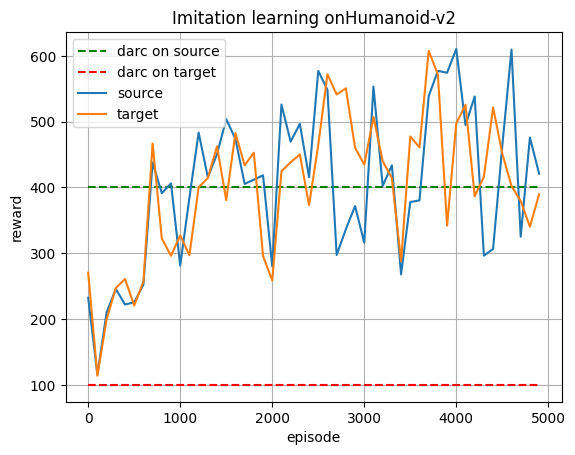

In [26]:
length = np.array(list(range(len(src_bs_3)))) *100
darc_source = np.ones_like(length) * 400
darc_target = np.ones_like(length) * 100
plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_3, label="source")
plt.plot(length, tgt_bs_3, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


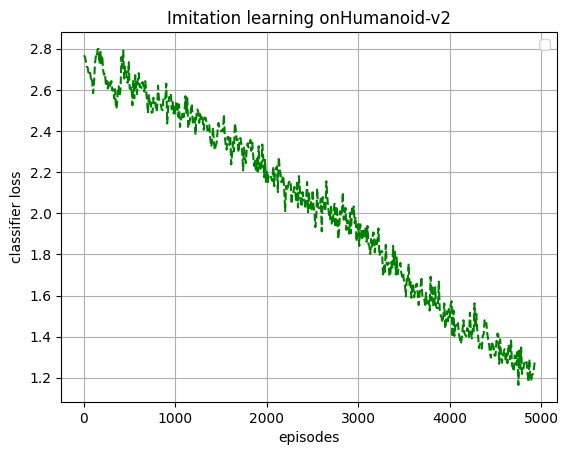

In [24]:
loss_length_3 = np.array(list(range(len(classifier_loss_3)))) * 10
plt.plot(loss_length_3, classifier_loss_3, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [9]:
IL_4 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10000,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_4, tgt_bs_4, classifier_loss_4 = IL_4.train(5000, deterministic=False)


index: 0, steps: 41, total_rewards: 209.75055641901923, total_reward_adv: 178.3438, acc gen: 0, acc expert: 0
eval reward: 140.75860319777402
index: 1, steps: 19, total_rewards: 94.07284943694454, total_reward_adv: 86.2668, acc gen: 0, acc expert: 0
index: 2, steps: 26, total_rewards: 130.30558957487315, total_reward_adv: 130.313, acc gen: 0, acc expert: 0
index: 3, steps: 22, total_rewards: 108.54697563392864, total_reward_adv: 100.1665, acc gen: 0, acc expert: 0
index: 4, steps: 19, total_rewards: 95.55308537274324, total_reward_adv: 100.4615, acc gen: 0, acc expert: 0
index: 5, steps: 29, total_rewards: 153.07362204277493, total_reward_adv: 140.1141, acc gen: 0, acc expert: 0
index: 6, steps: 18, total_rewards: 88.49822388739625, total_reward_adv: 81.3454, acc gen: 0, acc expert: 0
index: 7, steps: 29, total_rewards: 143.8231985612425, total_reward_adv: 136.767, acc gen: 0, acc expert: 0
index: 8, steps: 35, total_rewards: 176.58098059358554, total_reward_adv: 152.9468, acc gen: 0, 

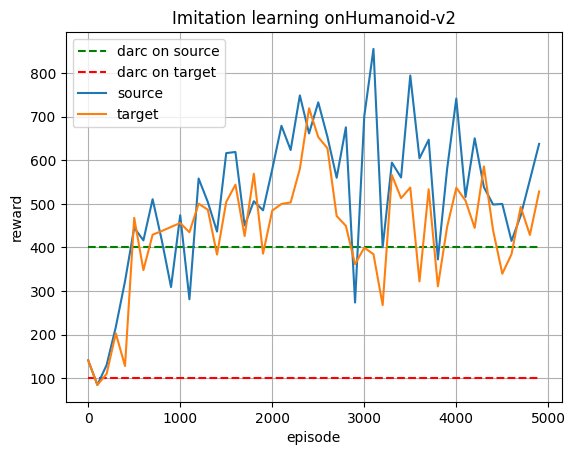

In [10]:
length = np.array(list(range(len(src_bs_4)))) *100
darc_source = np.ones_like(length) * 400
darc_target = np.ones_like(length) * 100
plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_4, label="source")
plt.plot(length, tgt_bs_4, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


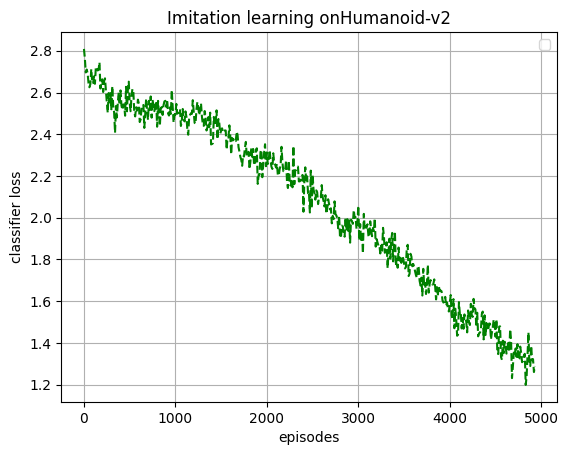

In [11]:
loss_length_4 = np.array(list(range(len(classifier_loss_4)))) * 10
plt.plot(loss_length_4, classifier_loss_4, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()